In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from sklearn.metrics import accuracy_score, precision_score, recall_score, zero_one_loss

from skmultiflow.data import FileStream
from skmultiflow.lazy import KNNClassifier
from skmultiflow.trees import HoeffdingTreeClassifier, \
    HoeffdingAdaptiveTreeClassifier, \
    ExtremelyFastDecisionTreeClassifier
from skmultiflow.meta import AdaptiveRandomForestClassifier, \
    LeveragingBaggingClassifier, \
    OnlineBoostingClassifier

from dmt.DMT import DynamicModelTree
from fimtdd.FIMTDD import FIMTDDClassifier

In [2]:
# Utils
def save(path, obj):
    filehandler = open(path, 'wb')
    pickle.dump(obj, filehandler)
    filehandler.close()

def load(path):
    filehandler = open(path, 'rb')
    obj = pickle.load(filehandler)
    filehandler.close()
    return obj

# Preparation
Load data sets and specify hyperparameters

In [3]:
# Load Data
"""
NOTE: Some data sets cannot be provided, as this would exceed the file size limit of Github. 
However, we downloaded the raw datasets from https://www.openml.org/search?type=data and provide the original references in the paper.
The synthetic data streams can be generated right-away by running the synth_data Notebook.
"""

cat_features= {
    'electricity': [1, 2],
    'airlines': [0, 4],
    'bank_marketing': [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 14, 15],
    'sea': None,
    'agrawal': [3, 4, 5, 6, 7],
    'hyperplane': None,
    'tueiq': [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75],
    'poker': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'kdd': [ 1,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    'covertype': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53],
    'gas': None,
    'insects_abrupt': None,
    'insects_inc': None
}

datasets = {
    'electricity': FileStream('./data/electricity.csv', target_idx=-1, cat_features=cat_features['electricity']),
    'airlines': FileStream('./data/airlines.csv', target_idx=-1, cat_features=cat_features['airlines']),
    'bank_marketing': FileStream('./data/bank_marketing.csv', target_idx=-1, cat_features=cat_features['bank_marketing']),
    'sea': FileStream('./data/synthetic/sea.csv', target_idx=-1, cat_features=cat_features['sea']),
    #'agrawal': FileStream('./data/synthetic/agrawal_inc.csv', target_idx=-1, cat_features=cat_features['agrawal']),
    #'hyperplane': FileStream('./data/synthetic/hyperplane.csv', target_idx=-1, cat_features=cat_features['hyperplane']),
    'tueiq': FileStream('./data/iq.csv', target_idx=-1, cat_features=cat_features['tueiq']),
    #'poker': FileStream('./data/poker.csv', target_idx=-1, cat_features=cat_features['poker']),
    #'kdd': FileStream('./data/kdd.csv', target_idx=-1, cat_features=cat_features['kdd']),
    #'covertype': FileStream('./data/covertype.csv', target_idx=-1, cat_features=cat_features['covertype']),
    #'gas': FileStream('./data/gas.csv', target_idx=-1, cat_features=cat_features['gas']),
    #'insects_abrupt': FileStream('./data/insects_abrupt.csv', target_idx=-1, cat_features=cat_features['insects_abrupt']),
    #'insects_inc': FileStream('./data/insects_inc.csv', target_idx=-1, cat_features=cat_features['insects_inc'])
}

In [4]:
general_param = dict()
general_param['batch_size'] = [0.001] # , 0.005, 0.01]
general_param['measures'] = ['time', 'accuracy', 'recall', 'precision', 'error', 'n_param', 'n_nodes', 'n_leaves', 'depth']

# Evaluation

NOTE: Pre-trained statistics can be loaded in the next cell!

In [ ]:
stats = dict()
models = dict()

for stream_name, stream in datasets.items():
    print(stream_name)
    stats[stream_name] = dict()
    models[stream_name] = dict()

    for bs in general_param['batch_size']:
        print('batch-size = {}'.format(bs))
        stream.restart()
        models[stream_name][bs] = dict()
        stats[stream_name][bs] = dict()

        # Initialize Models
        models[stream_name][bs]['dmt'] = DynamicModelTree(n_classes=stream.n_classes,
                                                          learning_rate=0.05,
                                                          epsilon=10e-8,
                                                          n_saved_candidates=3 * stream.n_features,
                                                          p_replaceable_candidates=0.5,
                                                          cat_features=stream.cat_features)
        
        models[stream_name][bs]['fimtdd'] = FIMTDDClassifier(attr=np.arange(stream.n_features), classes=stream.target_values, delta=0.01, n_min=1, tau=0.05, lr=0.01)
        #models[stream_name][bs]['knn'] = KNNClassifier()  # may be included as benchmark
        models[stream_name][bs]['ht_mc'] = HoeffdingTreeClassifier(leaf_prediction='mc', binary_split=True, split_confidence=0.01)
        models[stream_name][bs]['ht_nba'] = HoeffdingTreeClassifier(leaf_prediction='nba', binary_split=True, split_confidence=0.01)
        models[stream_name][bs]['ht_ada'] = HoeffdingAdaptiveTreeClassifier(leaf_prediction='mc', binary_split=True, bootstrap_sampling=False, split_confidence=0.01, random_state=0)
        models[stream_name][bs]['efdt'] = ExtremelyFastDecisionTreeClassifier(leaf_prediction='mc', binary_split=True, min_samples_reevaluate=1000, split_confidence=0.01)
        models[stream_name][bs]['forest'] = AdaptiveRandomForestClassifier(n_estimators=3, leaf_prediction='mc', split_confidence=0.01, binary_split=True, random_state=0)
        models[stream_name][bs]['bagging'] = LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier(leaf_prediction='mc', binary_split=True, split_confidence=0.01), n_estimators=3, random_state=0)
        
        # Initial training
        X, y = stream.next_sample(round(stream.n_samples * bs))

        for mdl_name, mdl in models[stream_name][bs].items():
            if mdl_name in ['dmt', 'fimtdd']:
                mdl.partial_fit(X, y)
            else:  # skmultiflow models require class labels in first iteration
                mdl.partial_fit(X, y, classes=(stream.target_values))

            stats[stream_name][bs][mdl_name] = dict()
            for meas in general_param['measures']:  # initialize statistics
                stats[stream_name][bs][mdl_name][meas] = []

        itr = 0
        while stream.has_more_samples():
            X, y = stream.next_sample(round(stream.n_samples * bs))  # draw sample

            for mdl_name, mdl in models[stream_name][bs].items():
                start = time.time()
                y_pred = mdl.predict(X)
                mdl.partial_fit(X, y)

                # Save statistics
                stats[stream_name][bs][mdl_name]['time'].append(time.time() - start)
                stats[stream_name][bs][mdl_name]['accuracy'].append(accuracy_score(y, y_pred))
                stats[stream_name][bs][mdl_name]['recall'].append(recall_score(y, y_pred, average='weighted', zero_division=0))
                stats[stream_name][bs][mdl_name]['precision'].append(precision_score(y, y_pred, average='weighted', zero_division=0))
                stats[stream_name][bs][mdl_name]['error'].append(zero_one_loss(y, y_pred))
                
                # Save tree depth, no. of nodes, no. of leaves
                if mdl_name in ['dmt', 'fimtdd']:
                    stats[stream_name][bs][mdl_name]['n_nodes'].append(mdl.n_nodes()[0])
                    stats[stream_name][bs][mdl_name]['n_leaves'].append(mdl.n_nodes()[1])
                    stats[stream_name][bs][mdl_name]['depth'].append(mdl.n_nodes()[2])
                elif mdl_name in ['forest', 'bagging']:
                    n_nodes = 0
                    depth = 0
                    for weak_learner in mdl.ensemble:
                        if mdl_name == 'forest':
                            n_nodes += weak_learner.classifier.get_model_measurements['Tree size (nodes)']
                            depth += weak_learner.classifier.get_model_measurements['Tree depth']
                        else:
                            n_nodes += weak_learner.get_model_measurements['Tree size (nodes)']
                            depth += weak_learner.get_model_measurements['Tree depth']
                    stats[stream_name][bs][mdl_name]['depth'].append(depth/mdl.n_estimators)  # average depth per estimator
                    stats[stream_name][bs][mdl_name]['n_nodes'].append(n_nodes)  # total nodes
                elif mdl_name != 'knn':  # all others but knn are HT based models
                    stats[stream_name][bs][mdl_name]['n_nodes'].append(mdl.get_model_measurements['Tree size (nodes)'])
                    stats[stream_name][bs][mdl_name]['n_leaves'].append(mdl.get_model_measurements['Tree size (leaves)'])
                    stats[stream_name][bs][mdl_name]['depth'].append(mdl.measure_tree_depth())

            # Print update to console
            itr += 1
            if itr % 100 == 0:
                print('Iteration {}/{}'.format(itr, round(1 / bs)))
                results = []
                for mdl_name in stats[stream_name][bs].keys():
                    results.append(mdl_name + ':' + str(round(np.mean(stats[stream_name][bs][mdl_name]['error']), 2)) 
                                   + '(' + str(round(np.mean(stats[stream_name][bs][mdl_name]['n_nodes']), 2)) 
                                   + '; ' + str(round(np.mean(stats[stream_name][bs][mdl_name]['time']), 2)) + ')')
                print(results)
            
        # Intermediate save
        #print('Save models and stats...')
        #save('./trained_models/models_{}_{}.obj'.format(stream_name, str(bs)), models)
        #save('./trained_models/stats_{}_{}.obj'.format(stream_name, str(bs)), stats)

In [ ]:
# Final Save
#save('./trained_models/models.obj', models)
save('./trained_models/stats.obj', stats)

# Illustrate Results

In [5]:
# Load pre-trained stats and/or models
stats = load('./trained_models/stats.obj')
#models = load('./trained_models/models_new.obj')  # NOTE: the models object is ~1Gb and can thus not be provided on Github

### Compute F1 Score

In [ ]:
""" Note: the provided stats file already includes the F1 measures
for data in stats.keys():
    for mdl in stats[data][0.001]:
        numerator = 2 * np.asarray(stats[data][0.001][mdl]['precision']) * np.asarray(stats[data][0.001][mdl]['recall'])
        denominator = np.asarray(stats[data][0.001][mdl]['precision']) + np.asarray(stats[data][0.001][mdl]['recall'])
        stats[data][0.001][mdl]['f1'] = list(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0))
"""

## Tables

In [6]:
# Create Table of all saved measures
general_param['measures'] = ['time', 'error', 'n_nodes', 'precision', 'recall', 'f1']
#general_param['measures'] = ['time', 'accuracy', 'recall', 'precision', 'error', 'n_param', 'n_nodes', 'n_leaves', 'depth']

aggregated_stats = dict()
considered_models = ['dmt','fimtdd','ht_mc','ht_nba','ht_ada','efdt','forest','bagging']

#considered_data = stats.keys()
considered_data = ['electricity', 'airlines', 'bank_marketing', 'tueiq', 'poker', 'kdd', 'covertype', 'gas', 'insects_abrupt', 'insects_inc', 'sea', 'agrawal', 'hyperplane']

for meas in general_param['measures']:
    aggregated_stats[meas] = dict()  # save all aggregated stats for scatter plot
    
    # Create empty DataFrame
    dataset_names = [name.upper() for name in considered_data]
    table = pd.DataFrame(0, index=[mdl_name.upper() for mdl_name in considered_models], columns=dataset_names)
    
    mean_per_mdl = dict()  # save per-model statistics
    std_per_mdl = dict()
    
    for stream_name in considered_data:  
        aggregated_stats[meas][stream_name] = dict()
        
        for mdl_name in considered_models:
            #####################################
            # We consider batch size 0.001 here
            #####################################
            
            mean = np.mean(stats[stream_name][0.001][mdl_name][meas])
            std = np.std(stats[stream_name][0.001][mdl_name][meas])
            
            """
            mean = 0
            std = 0            
            
            for bs in stats[stream_name].keys():  # get mean results over all batches
                mean += np.mean(stats[stream_name][bs][mdl_name][meas]) / len(stats[stream_name].keys())
                std += np.std(stats[stream_name][bs][mdl_name][meas]) / len(stats[stream_name].keys())
            """
            
            if mdl_name in mean_per_mdl:  # save values for overall average results per model
                mean_per_mdl[mdl_name] += mean / len(stats.keys())
                std_per_mdl[mdl_name] += std / len(stats.keys())
            else:
                mean_per_mdl[mdl_name] = mean / len(stats.keys())
                std_per_mdl[mdl_name] = std / len(stats.keys())
                
            aggregated_stats[meas][stream_name][mdl_name] = [mean, std]
            
            if meas in ['n_nodes', 'n_leaves', 'depth']:
                table.loc[mdl_name.upper(), stream_name.upper()] = '{:0.1f}'.format(mean) + ' ' + u"\u00B1" + ' ' + '{:0.1f}'.format(std)
            else:
                table.loc[mdl_name.upper(), stream_name.upper()] = '{:0.2f}'.format(mean) + ' ' + u"\u00B1" + ' ' + '{:0.2f}'.format(std)
    
    for mdl_name in mean_per_mdl.keys():  # print average measure per model
        if meas in ['n_nodes', 'n_leaves', 'depth']:
            table.loc[mdl_name.upper(),'Mean'] = '{:0.1f}'.format(mean_per_mdl[mdl_name]) + ' ' + u"\u00B1" + ' ' + '{:0.1f}'.format(std_per_mdl[mdl_name])
        else:
            table.loc[mdl_name.upper(),'Mean'] = '{:0.2f}'.format(mean_per_mdl[mdl_name]) + ' ' + u"\u00B1" + ' ' + '{:0.2f}'.format(std_per_mdl[mdl_name])
    
    """ optional: print rank
    if meas in ['time', 'n_nodes', 'n_leaves', 'error', 'depth']:  # print rank of each model according to average measure (over all data sets)
        table.loc[:,'Rank'] = pd.Series(mean_per_mdl.values()).rank(ascending=True).to_list()
    else:  # everything else is ranked in descending order
        table.loc[:,'Rank'] = pd.Series(mean_per_mdl.values()).rank(ascending=False).to_list()
    """
        
    #table.to_latex('./tables/{}.tex'.format(meas))  # Save as latex table
    
    print('##################################')
    print(meas)
    print('##################################')
    print(table)

##################################
time
##################################
         ELECTRICITY     AIRLINES BANK_MARKETING        TUEIQ          POKER  \
DMT      0.05 ± 0.02  0.49 ± 0.17    0.03 ± 0.01  0.06 ± 0.02    0.08 ± 0.00   
FIMTDD   0.06 ± 0.04  0.18 ± 0.09    0.05 ± 0.02  0.01 ± 0.00    0.08 ± 0.01   
HT_MC    0.00 ± 0.00  0.03 ± 0.01    0.00 ± 0.00  0.00 ± 0.01    0.11 ± 0.02   
HT_NBA   0.00 ± 0.00  0.05 ± 0.01    0.01 ± 0.00  0.01 ± 0.01    0.26 ± 0.02   
HT_ADA   0.01 ± 0.01  0.20 ± 0.06    0.02 ± 0.01  0.02 ± 0.01    0.74 ± 0.12   
EFDT     0.29 ± 0.14  3.37 ± 1.64    0.71 ± 0.25  0.24 ± 0.24  29.87 ± 13.57   
FOREST   0.06 ± 0.01  0.90 ± 0.24    0.05 ± 0.01  0.04 ± 0.01    2.61 ± 0.34   
BAGGING  0.04 ± 0.01  0.58 ± 0.03    0.05 ± 0.01  0.07 ± 0.03    1.72 ± 0.17   

                  KDD      COVERTYPE          GAS INSECTS_ABRUPT  \
DMT       0.51 ± 0.16    0.48 ± 0.19  0.28 ± 0.16    0.47 ± 0.20   
FIMTDD    0.08 ± 0.01    0.25 ± 0.08  0.26 ± 0.20    1.34 ± 0.94   


##################################
recall
##################################
         ELECTRICITY     AIRLINES BANK_MARKETING        TUEIQ        POKER  \
DMT      0.75 ± 0.19  0.65 ± 0.06    0.90 ± 0.12  0.82 ± 0.18  0.48 ± 0.03   
FIMTDD   0.76 ± 0.19  0.57 ± 0.12    0.88 ± 0.14  0.77 ± 0.22  0.41 ± 0.09   
HT_MC    0.75 ± 0.20  0.64 ± 0.07    0.89 ± 0.14  0.82 ± 0.18  0.51 ± 0.02   
HT_NBA   0.77 ± 0.17  0.65 ± 0.06    0.89 ± 0.13  0.81 ± 0.18  0.52 ± 0.02   
HT_ADA   0.76 ± 0.20  0.64 ± 0.07    0.90 ± 0.13  0.82 ± 0.19  0.51 ± 0.02   
EFDT     0.75 ± 0.20  0.64 ± 0.08    0.90 ± 0.13  0.82 ± 0.18  0.51 ± 0.02   
FOREST   0.78 ± 0.15  0.65 ± 0.06    0.90 ± 0.12  0.82 ± 0.18  0.53 ± 0.02   
BAGGING  0.79 ± 0.17  0.66 ± 0.06    0.90 ± 0.12  0.83 ± 0.18  0.55 ± 0.02   

                 KDD    COVERTYPE          GAS INSECTS_ABRUPT  INSECTS_INC  \
DMT      0.99 ± 0.01  0.80 ± 0.09  0.83 ± 0.24    0.75 ± 0.09  0.75 ± 0.07   
FIMTDD   0.99 ± 0.01  0.80 ± 0.11  0.80 ± 0.25    0.73 ± 0.10  0

## Figures

f1-electricity-0.001


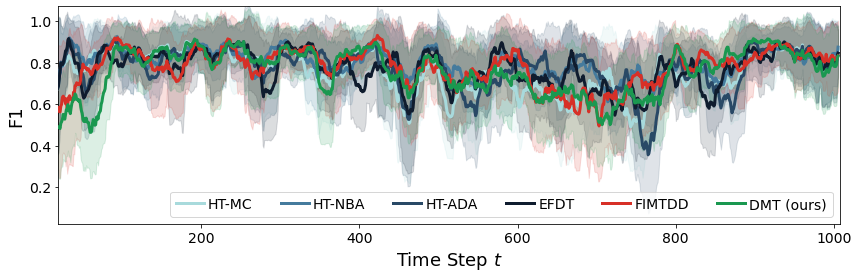

f1-airlines-0.001


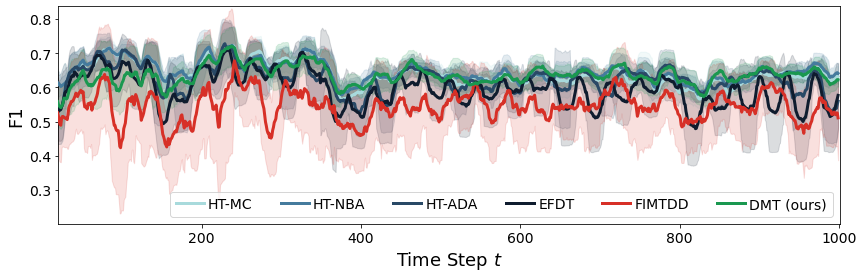

f1-bank_marketing-0.001


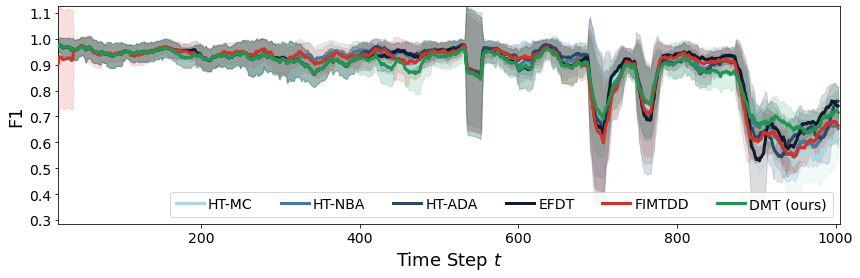

f1-sea-0.001


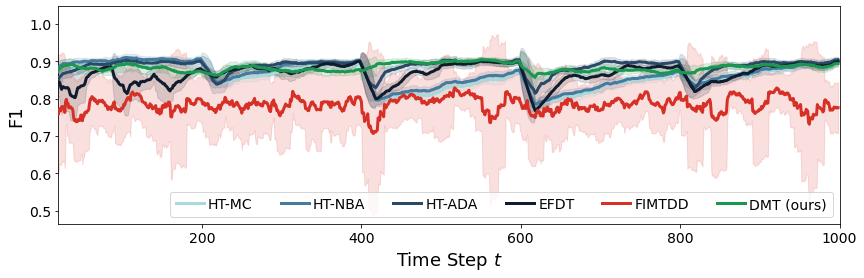

f1-agrawal-0.001


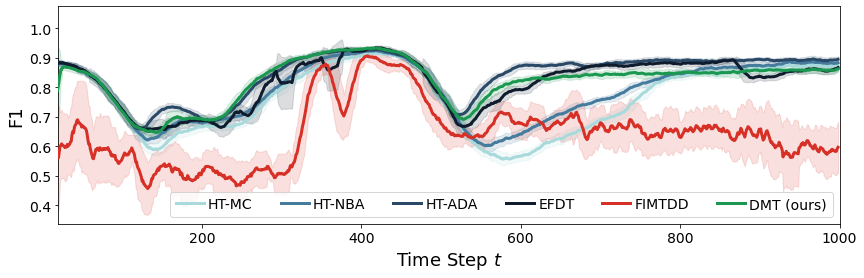

f1-hyperplane-0.001


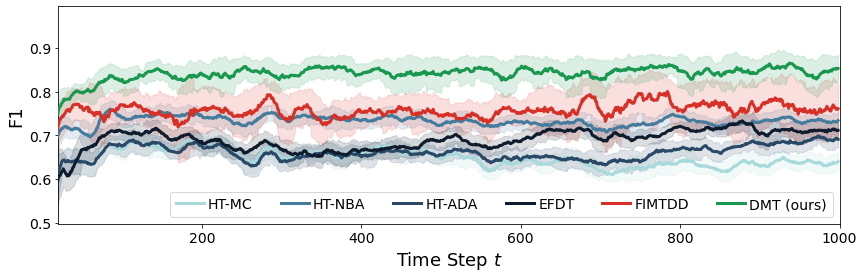

f1-tueiq-0.001


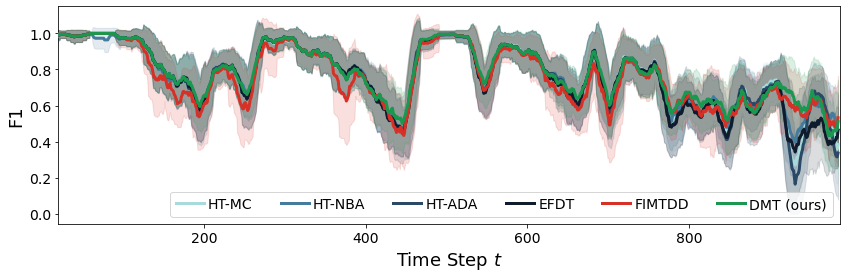

f1-poker-0.001


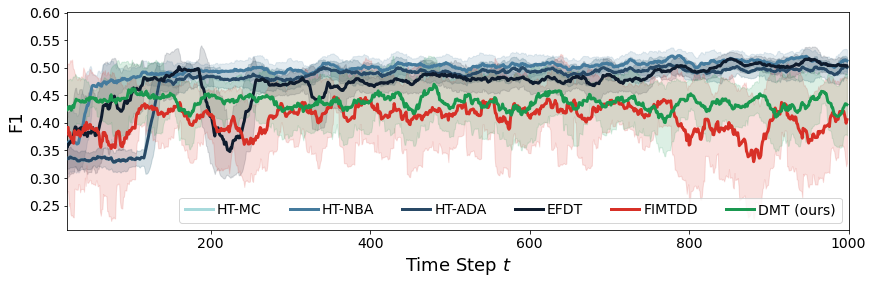

f1-kdd-0.001


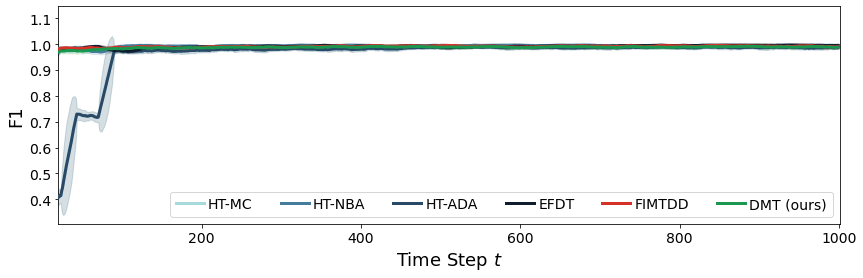

f1-covertype-0.001


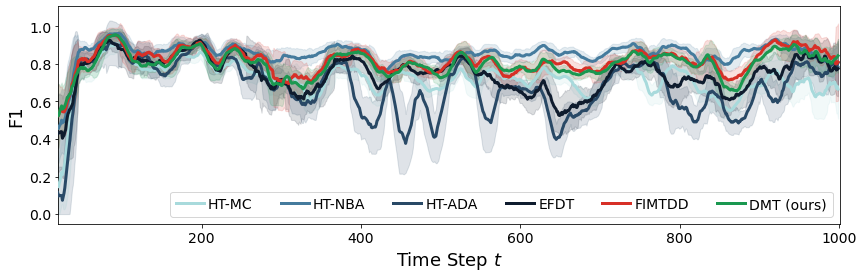

f1-gas-0.001


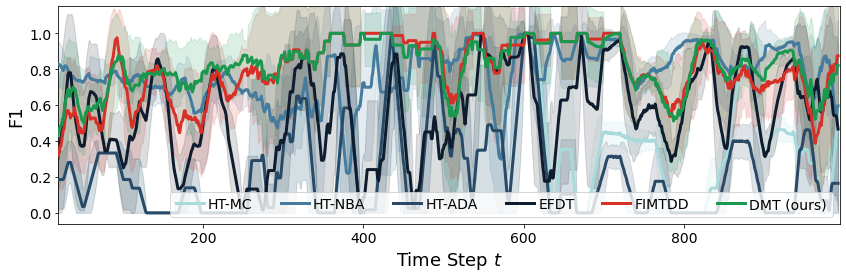

f1-insects_abrupt-0.001


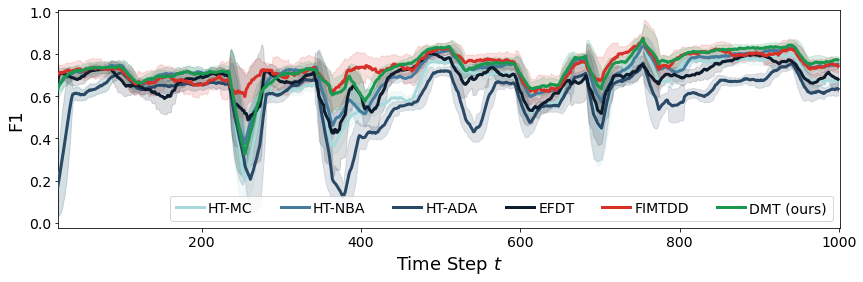

f1-insects_inc-0.001


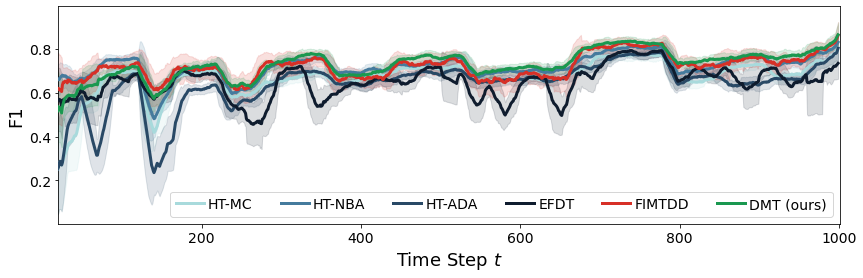

n_nodes-electricity-0.001


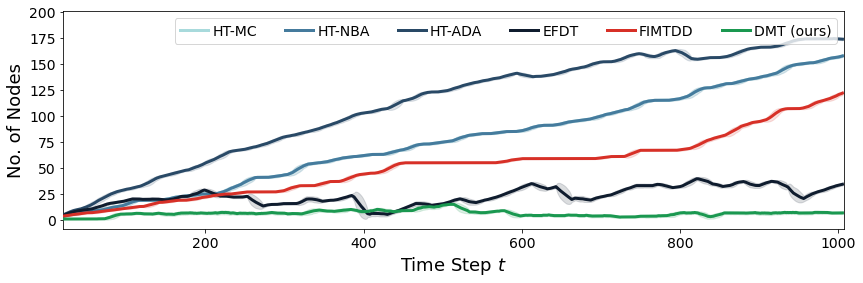

n_nodes-airlines-0.001


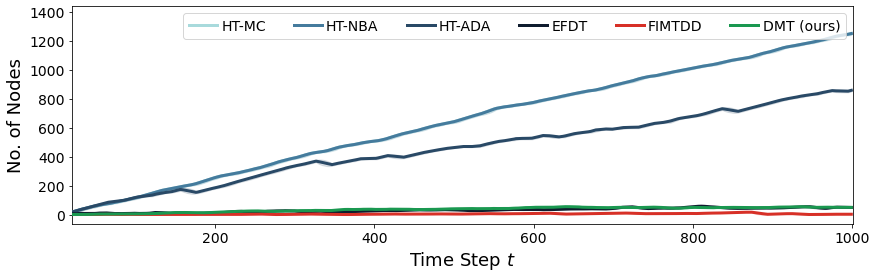

n_nodes-bank_marketing-0.001


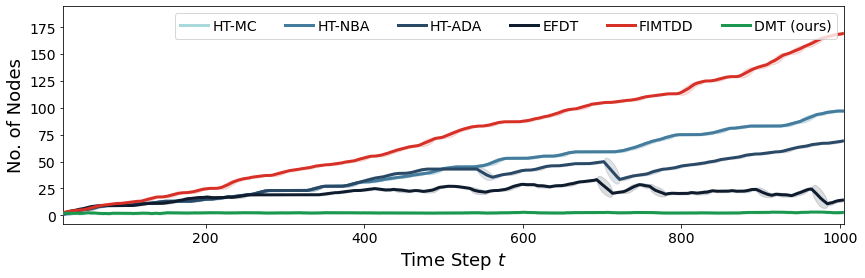

n_nodes-sea-0.001


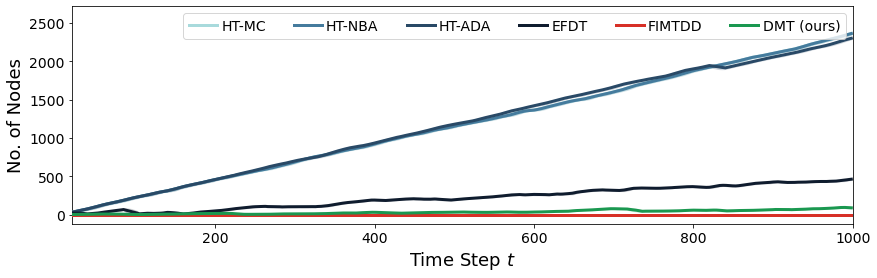

n_nodes-agrawal-0.001


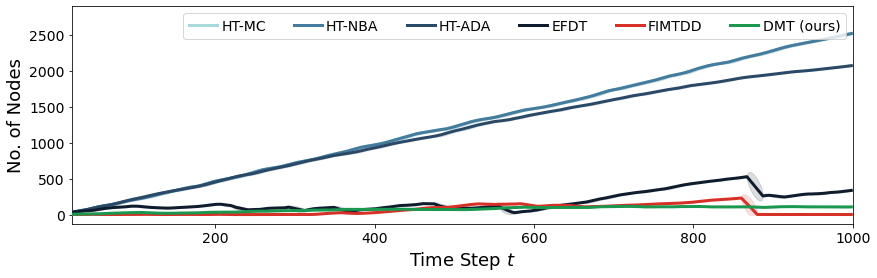

n_nodes-hyperplane-0.001


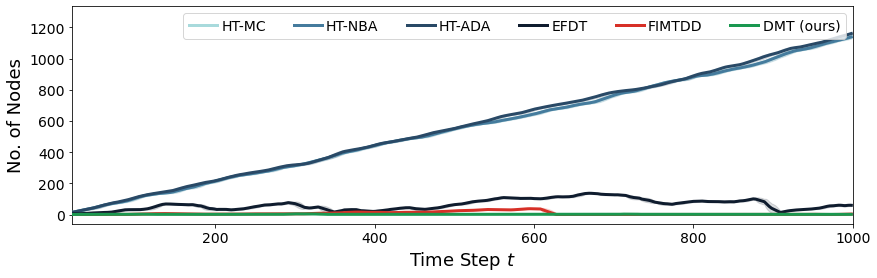

n_nodes-tueiq-0.001


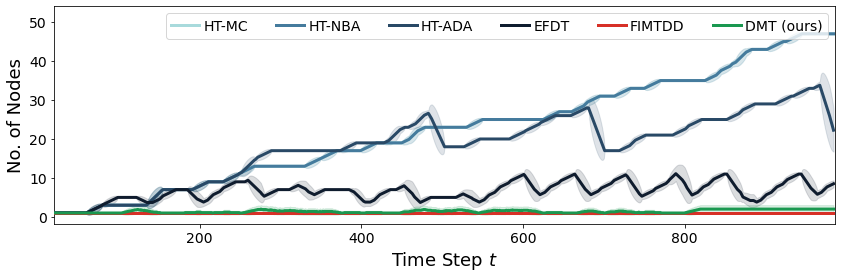

n_nodes-poker-0.001


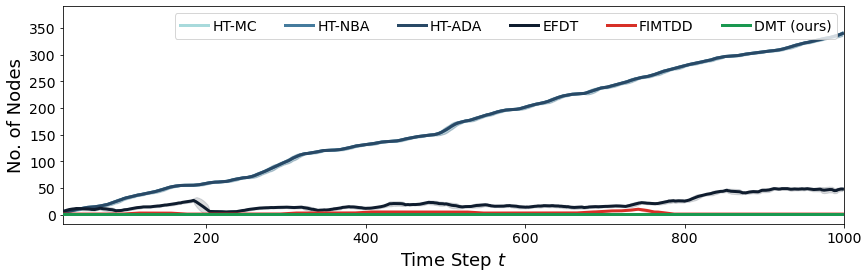

n_nodes-kdd-0.001


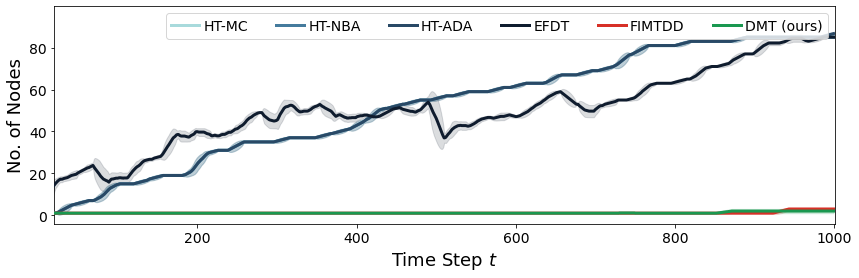

n_nodes-covertype-0.001


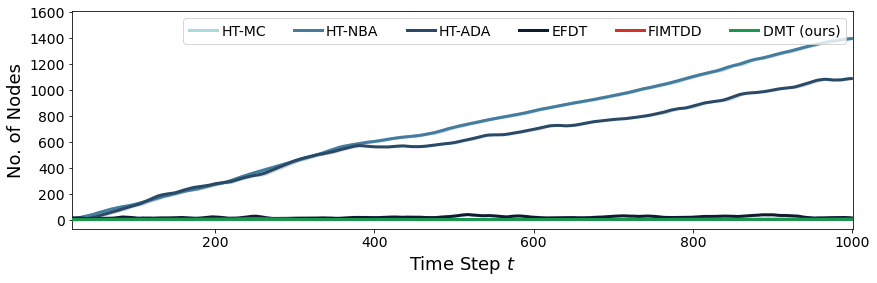

n_nodes-gas-0.001


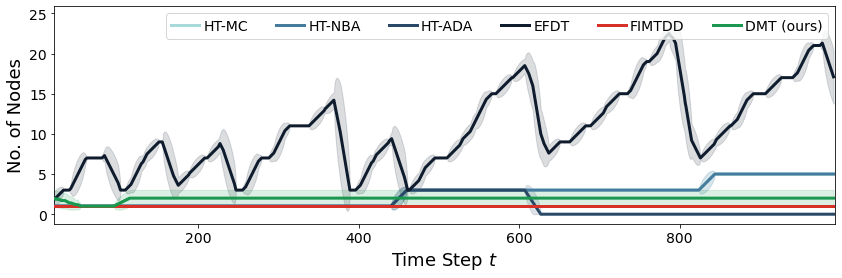

n_nodes-insects_abrupt-0.001


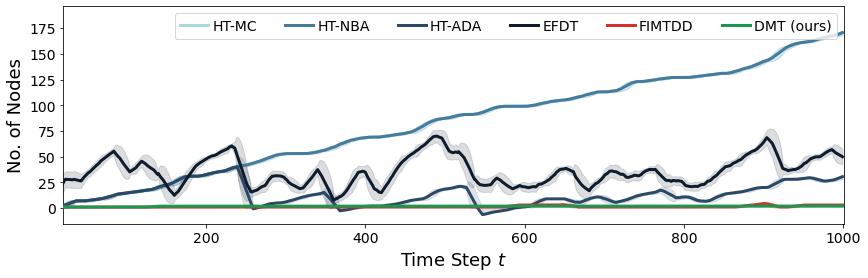

n_nodes-insects_inc-0.001


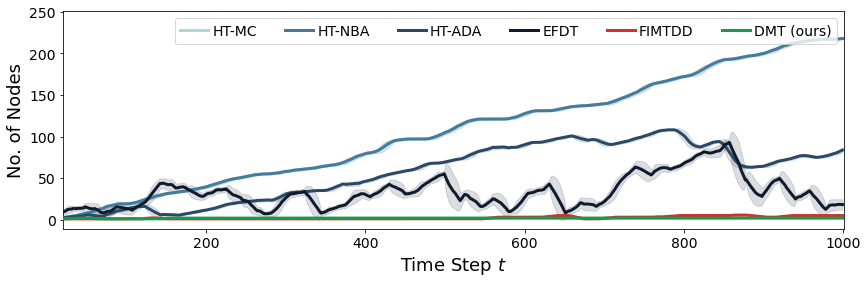

In [7]:
palette = palette = ["#a8dadc","#457b9d","#294966","#0f1c2e","#d73027","#1a9850"]

considered_models = ['ht_mc','ht_nba','ht_ada','efdt','fimtdd','dmt']  # stand-alone models

# Create plot for all saved measures, datasets and batch sizes
for meas in ['f1', 'n_nodes']:  #  general_param['measures']:
    for stream_name in stats.keys():
        for bs in [0.001]:  # stats[stream_name].keys():
            print('{}-{}-{}'.format(meas, stream_name, bs))
            fig = plt.figure(figsize=(14, 4))
            col_i = 0  # start with 3 for ensemble models
            legend_names = []
            z_i = 20
            measures = []
            max_y = 0

            for mdl_name in considered_models:
                if not (mdl_name == 'knn' and meas in ['n_nodes', 'n_leaves', 'depth']):
                    n_mvg = 20  # size of moving window
                    
                    measures = pd.Series(stats[stream_name][bs][mdl_name][meas]).rolling(n_mvg).mean()
                    errors = pd.Series(stats[stream_name][bs][mdl_name][meas]).rolling(n_mvg).std()
                    
                    plt.plot(np.arange(measures.shape[0]), measures, color=palette[col_i], ls='-', lw=3, zorder=z_i+col_i)

                    upper_error = measures + errors
                    lower_error = measures - errors
                    lower_error[lower_error < 0] = 0  # set lower limit of error bound to zero
                    plt.fill_between(np.arange(measures.shape[0]), lower_error, upper_error, color=palette[col_i], alpha=0.15)
                    
                    if mdl_name == 'dmt':
                        legend_names.append('DMT (ours)')
                    else:
                        legend_names.append(mdl_name.upper().replace('_','-'))

                    if np.max(measures) > max_y:  # identify max measure to set y axis limit
                        max_y = np.max(measures)

                col_i += 1    
            
            if meas in ['f1', 'recall', 'precision']:
                l = plt.legend(legend_names, loc='lower right', prop={'size': 14}, ncol=6, handletextpad=0.3)
            else:
                l = plt.legend(legend_names, loc='upper right', prop={'size': 14}, ncol=6, handletextpad=0.3)
            l.set_zorder(30)
            if meas == 'time':
                plt.ylabel(meas.capitalize() + ' (sec.)', fontsize=18)
            elif meas == 'n_nodes':
                plt.ylabel('No. of Nodes', fontsize=18)
            else:
                plt.ylabel(meas.capitalize(), fontsize=18)
            plt.yticks(fontsize=14)
            plt.xticks(fontsize=14)
            plt.xlabel('Time Step $t$', fontsize=18)
            plt.xlim(n_mvg, measures.shape[0] + 1)
            plt.ylim(top=max_y * 1.15)
            #plt.savefig('./figures/stand_alone_classifiers/{}_{}.pdf'.format(meas, stream_name), format='pdf', bbox_inches='tight')
            plt.show()

## Scatter Plot

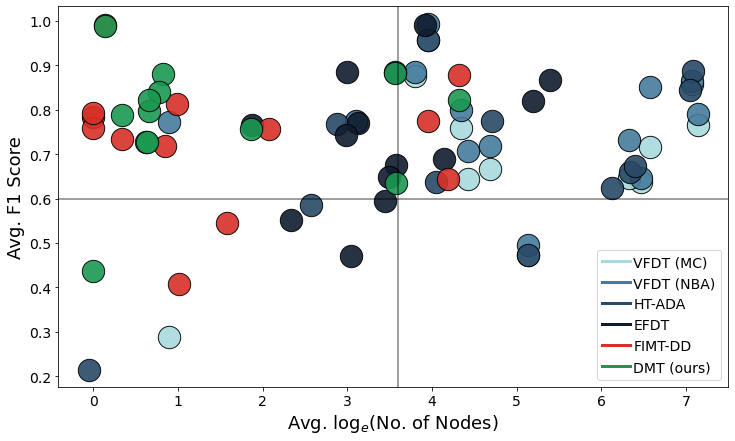

In [8]:
palette = ["#a8dadc","#457b9d","#294966","#0f1c2e","#d73027","#1a9850"]
markers = ['o','p','s','8','d','*']

considered_streams = stats.keys()

considered_models = ['ht_mc','ht_nba','ht_ada','efdt','fimtdd','dmt']  # stand-alone models

mdl_names = ['VFDT (MC)','VFDT (NBA)', 'HT-ADA', 'EFDT', 'FIMT-DD', 'DMT (ours)']


fig = plt.figure(figsize=(12, 7))
handles_mdl = []  # legend handles
handles_stream = []
mdl_i = 0

""" Optionally, we may scale the size of the markers acc. to the standard deviations
# Identify max standard deviation
max_std = 0
for mdl_name in considered_models:
    for stream_name in considered_streams:
        if aggregated_stats['error'][stream_name][mdl_name][1] > max_std:
            max_std = aggregated_stats['error'][stream_name][mdl_name][1]
"""

# Plot data points
for i, mdl_name in enumerate(considered_models):
    stream_i = 0
    handles_mdl.append(Line2D([0], [0], lw=3, color=palette[mdl_i], label=mdl_names[i]))

    for stream_name in considered_streams:
        x = np.log(aggregated_stats['n_nodes'][stream_name][mdl_name][0])
        y = aggregated_stats['f1'][stream_name][mdl_name][0]
        size=500
        # size = (aggregated_stats['f1'][stream_name][mdl_name][1] / max_std) * 2000  # scale according to standard deviation

        plt.scatter(x, y, s=size, c=palette[mdl_i], edgecolors='black', marker='o', alpha=.9)
        # plt.scatter(x, y, s=size, c=palette[mdl_i], edgecolors='black', marker=markers[stream_i], alpha=0.8)  # distinguish data sets
        #plt.scatter(x, y, s=20, c='black', marker='x')

        #if len(handles_stream) < len(considered_streams):
        #    handles_stream.append(Line2D([0], [0], marker=markers[stream_i], label=stream_name.upper(), markersize=15, color='w', markeredgecolor='black'))

        stream_i += 1

    mdl_i += 1

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim(left=-0.2,right=6.8) # ADJUST ACCORDINGLY!
#plt.ylim(top=1.01) # ADJUST ACCORDINGLY!
plt.xlabel('Avg. $\log_e$(No. of Nodes)', fontsize=18)
plt.ylabel('Avg. F1 Score', fontsize=18)

# Grid
plt.axhline(.6, color='black', alpha=0.5)
plt.axvline(3.6, color='black', alpha=0.5)

first_legend = plt.legend(handles=handles_mdl, prop={'size': 14}, handletextpad=0.2, loc='lower right')
#plt.gca().add_artist(first_legend)
#plt.legend(handles=handles_stream, prop={'size': 14}, handletextpad=0.2, loc='upper right', bbox_to_anchor=(0.875, 1))
#plt.savefig('./figures/scatter/scatter.pdf', format='pdf', bbox_inches='tight')
plt.show()